##  OSMから取得した、道路ネットワークデータを編集する
重み付けを行ったルーティング、道路追加、削除などを試してみる

### まずは何も加工せずに、ルーティングを行う
黒がスタート地点（ナチュラルローソンアークヒルズ店）、青がゴール（100円ローソン元麻布店）

In [87]:
import folium
import networkx as nx
import osmnx as ox

ox.config(use_cache=True, log_console=True)

# 六本木交差点から半径1000ｍの道路ネットワークをOSMから生成する
ROPPONGI = (35.663236, 139.732275)
G = ox.graph_from_point(ROPPONGI, distance=1000, network_type='drive', simplify=False)

# 高速道路を除去
non_motorway = [ (u, v, k, data) for u, v, k, data in G.edges(keys=True, data=True)  if data['highway'] == 'motorway']
G.remove_edges_from(non_motorway)
G = ox.remove_isolated_nodes(G)

start_point = (35.6681770, 139.7397242)
start_node = ox.get_nearest_node(G, start_point)
end_point = (35.6578560, 139.7274620)
end_node = ox.get_nearest_node(G, end_point)

path = nx.shortest_path(G, start_node, end_node, weight='length')
map = ox.plot_route_folium(G, path, route_color='green')
folium.Marker( list(start_point), icon=folium.Icon(color='black')).add_to(map)
folium.Marker( list(end_point), icon=folium.Icon(color='blue')).add_to(map)

map


### 六本木通りを避けるように、六本木通りに重みを付ける

In [88]:
weights = {
            (499192175, 2590477971, 0): {'length':1000},
            (2590477971, 2138849615, 0): {'length':1000},
            (2590477966, 2590493981, 0): {'length':1000},
            (2590493981, 342022926, 0): {'length':1000}
          }

nx.set_edge_attributes(G, weights)

path = nx.shortest_path(G, start_node, end_node, weight='length')
map = ox.plot_route_folium(G, path, route_color='green')
folium.Marker( list(start_point), icon=folium.Icon(color='black')).add_to(map)
folium.Marker( list(end_point), icon=folium.Icon(color='blue')).add_to(map)

map

六本木通りを避けた！

### 道路ネットワークデータに、道路を追加する
ダウンロードしたOSM道路ネットワークデータを加工して、六本木通りを渡る直前のいびつな右左折をなくし、まっすぐ六本木通りを交差する道路を作成してみる

In [89]:
# add path from 499190948 to 1075233512
paths = (499190948, 1075233512)
G.add_path(paths, length=120)

path = nx.shortest_path(G, start_node, end_node, weight='length')
map = ox.plot_route_folium(G, path, route_color='green')
folium.Marker( list(start_point), icon=folium.Icon(color='black')).add_to(map)
folium.Marker( list(end_point), icon=folium.Icon(color='blue')).add_to(map)

map

まっすぐになった！

上で追加した道路を赤でプロット

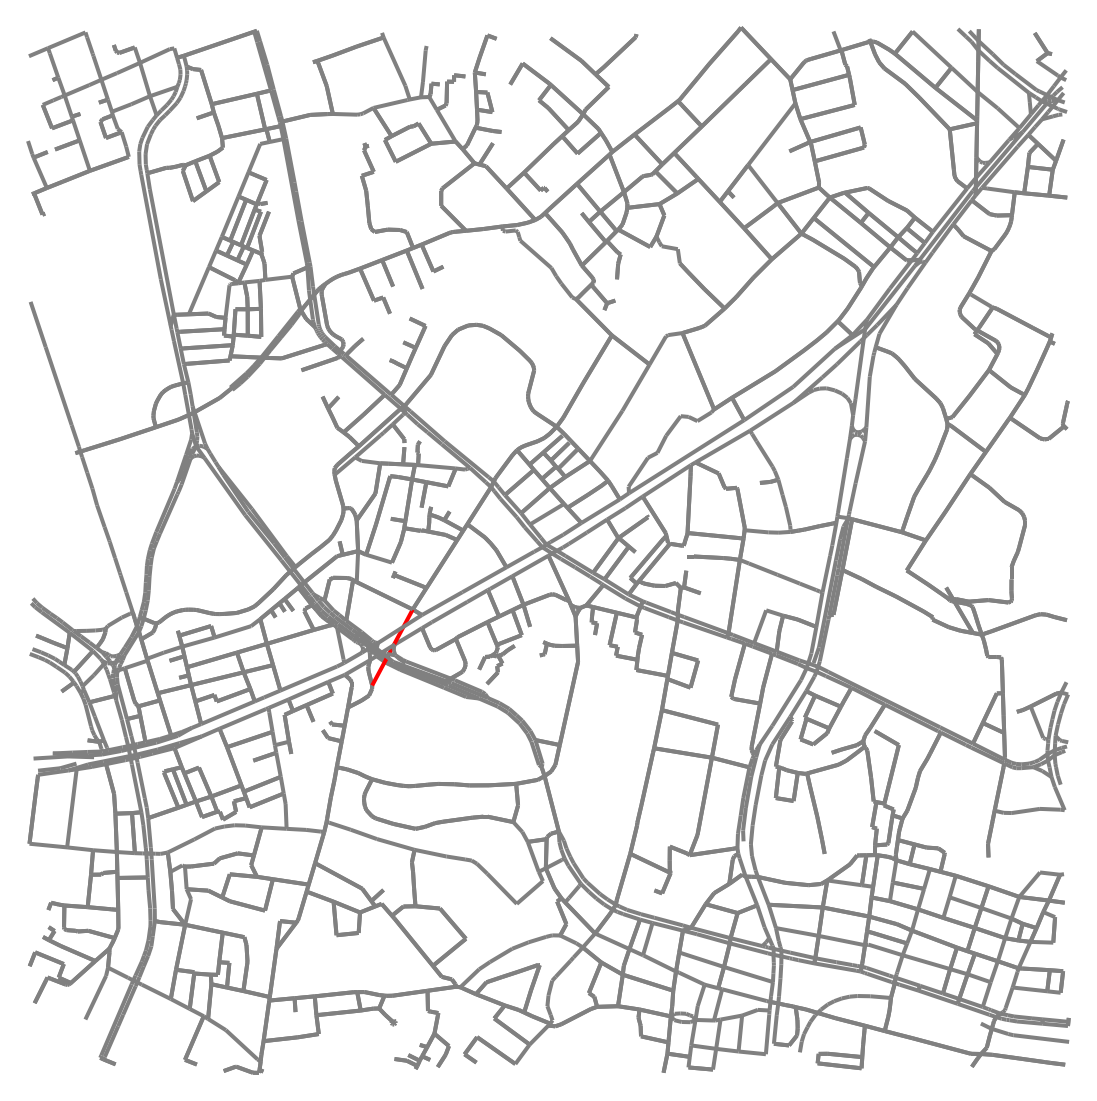

(<Figure size 1440x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x128a7b320>)

In [95]:
ec = ['r'  if u == 499190948  and v == 1075233512 else 'grey'  for u, v, data in G.edges(data=True) ]
ox.plot_graph(G, node_size=0, edge_color=ec, edge_linewidth=4, fig_height=20, fig_width=20)